In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models.efficientnet import EfficientNet_V2_S_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import numpy as np

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

# ImageFolder를 사용해 전체 데이터셋 로드
data_dir = 'dataset/train/nobreak/nobreak'  # 데이터셋 경로
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 데이터셋 크기 계산 및 분할
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# random_split으로 데이터셋 분할
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# 훈련 및 검증 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 전처리 및 증강 
def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))
    
    return new_data, targets, shuffled_targets, lam


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)  # np.int 대신 int 사용
    cut_h = int(H * cut_rat)  # np.int 대신 int 사용

    # 랜덤 위치 계산
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# 데이터 로더를 이용한 학습 루프에서 CutMix 적용
for images, labels in train_loader:
    images, targets, shuffled_targets, lam = cutmix(images, labels, alpha=1.0)
    # 훈련 코드 작성
    # 예: loss = lam * criterion(model(images), targets) + (1 - lam) * criterion(model(images), shuffled_targets)
    pass

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet V2 모델 로딩
model = models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(full_dataset.classes))
model = model.to(device)

# 손실 함수 및 최적화 기법
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 훈련 루프
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # 검증
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


Epoch 1, Loss: 1.3152840029109607
Accuracy: 70.36%
F1-Score: 0.6744
Confusion Matrix:
[[61  7  0  1  0 13]
 [ 5 75  0 10  1 15]
 [ 0  4  0  2  1  4]
 [ 0  9  0 91  0  0]
 [ 6 20  0  2  4  9]
 [ 5 14  0  2  1 80]]
Epoch 2, Loss: 0.7415544634515588
Accuracy: 77.38%
F1-Score: 0.7693
Confusion Matrix:
[[66  5  1  0  0 10]
 [ 7 82  0  0  3 14]
 [ 1  2  2  0  2  4]
 [ 0  8  0 90  1  1]
 [ 4 11  0  0 19  7]
 [ 4 11  0  0  4 83]]
Epoch 3, Loss: 0.39845133008378925
Accuracy: 78.73%
F1-Score: 0.7873
Confusion Matrix:
[[68  5  1  0  1  7]
 [ 9 79  0  2  6 10]
 [ 2  2  4  1  1  1]
 [ 0  8  0 90  1  1]
 [ 2  8  0  0 28  3]
 [ 5 16  0  0  2 79]]
Epoch 4, Loss: 0.2099644380311171
Accuracy: 81.45%
F1-Score: 0.8142
Confusion Matrix:
[[69  4  1  0  1  7]
 [ 5 84  0  2  4 11]
 [ 1  1  5  1  1  2]
 [ 0  8  0 90  1  1]
 [ 1  7  1  0 27  5]
 [ 6 10  0  0  1 85]]
Epoch 5, Loss: 0.15209871575687872
Accuracy: 81.00%
F1-Score: 0.8097
Confusion Matrix:
[[70  4  1  0  1  6]
 [ 6 80  0  3  7 10]
 [ 1  2  6  1  1  

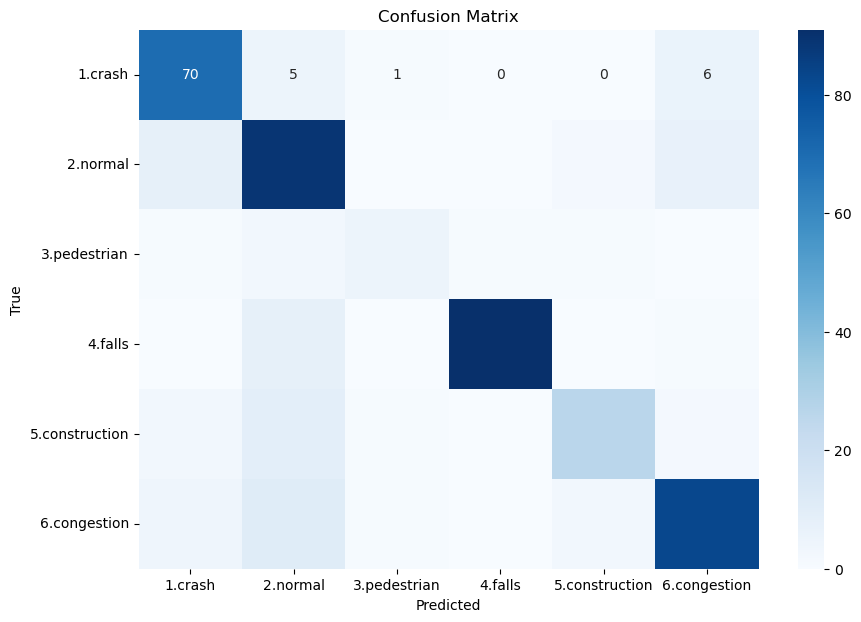

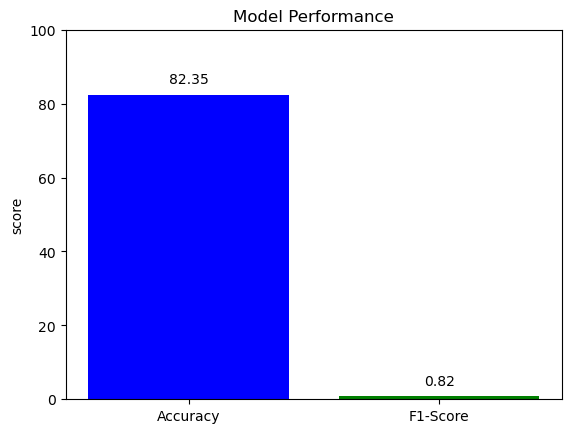

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 가정: 'all_labels'와 'all_preds'는 이미 계산된 상태입니다.
# 'acc'와 'f1'도 계산된 상태이고, 'cm'은 혼동행렬입니다.

# 혼동행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 정확도와 F1-Score 시각화
fig, ax = plt.subplots()
metrics = ['Accuracy', 'F1-Score']
values = [acc * 100, f1]

ax.bar(metrics, values, color=['blue', 'green'])
ax.set_ylim(0, 100)
ax.set_ylabel('score')
ax.set_title('Model Performance')
for i, v in enumerate(values):
    ax.text(i, v + 3, f"{v:.2f}", color='black', ha='center')
plt.show()
